## Predicción de Desagregación de Robos en Lakendd

Coder: LeninGF
Date: 2023-03-16

Objetivos:

* Predecir la desagregación de validados y seguimiento para un archivo obtenido desde lakendd

In [1]:
import pandas as pd

import os
# file_path_org=os.path.join(os.getcwd(), 'data/raw/requests/REPORTE_DESI_LAKENDD2_RobosAutosVehiculos.csv')
# file_path_org = os.path.join(os.getcwd(), 'data/raw/requests/REPORTE_DESI_LAKENDD2_RobosCarrosMotos.csv')
file_path_org = os.path.join(os.getcwd(), 'data/raw/requests/faltantes_robosFlacso.csv')
# xtest = pd.read_csv(file_path_org, parse_dates=['f_FECHA_PS'], converters={'d_NDD':str})
xtest = pd.read_csv(file_path_org, converters={'NDD':str})
xtest.shape

(14656, 2)

Obteniendo los relatos. Adaptar la columna de registro de las ndds segun el nombre que esta tenga

In [2]:
import html
from sqlalchemy import text, create_engine
from src.utils import extraer_relato, conectar_sql
conx = conectar_sql()
relatos_siaf = extraer_relato(sql_connection=conx, lista_ndds=list(set(xtest.NDD.to_list())))
relatos_siaf.shape

2023-10-23 15:13:17.941998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


conectando con big data database....


(14656, 2)

In [3]:
# relatos_siaf.rename(columns={'RELATO':'d_RELATO_SIAF', 'NDD': 'd_NDD'}, inplace=True)
relatos_siaf.rename(columns={'RELATO':'d_RELATO_SIAF'}, inplace=True)

In [4]:
print(xtest.shape)
# xtest = pd.merge(xtest, relatos_siaf, on='d_NDD', how='left')
xtest = pd.merge(xtest, relatos_siaf, on='NDD', how='left')
xtest.shape

(14656, 2)


(14656, 3)

Dando formato al texto

In [5]:
from src.utils import format_crimestory
format_crimestory(relato_label='d_RELATO_SIAF', dataf=xtest)


Contando las palabras

In [6]:
from src.utils import words_qty
words_qty(dataf=xtest, relato_label='d_RELATO_SIAF')

<AxesSubplot: >

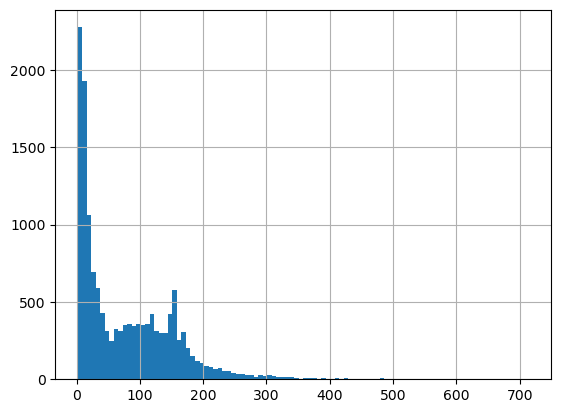

In [7]:
xtest.d_CANTIDAD_PALABRAS.hist(bins=100)

<AxesSubplot: >

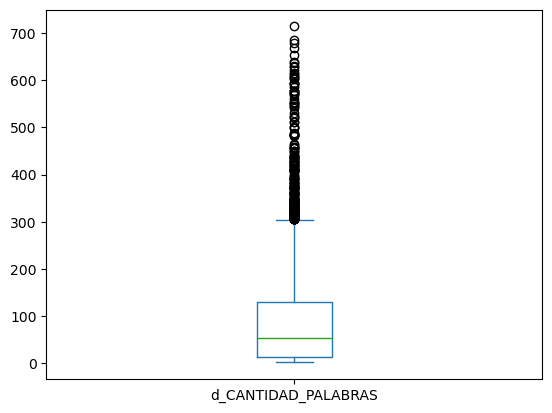

In [8]:
xtest.d_CANTIDAD_PALABRAS.plot.box()

In [9]:
xtest.d_CANTIDAD_PALABRAS.describe()

count    14656.000000
mean        79.525109
std         79.803590
min          2.000000
25%         14.000000
50%         53.000000
75%        130.000000
max        714.000000
Name: d_CANTIDAD_PALABRAS, dtype: float64

In [10]:
# xtest.to_csv('data/interim/delitosRobosAutosconRelato.csv')
# xtest.to_csv('data/interim/delitosRobosAutosMotosconRelato.csv', index=False)
# xtest.to_csv('data/interim/delitosRobosLaDefensaEspaciosAcuaticos.csv', index=False)

## Cargando Modelo de Machine Learning

Convierto el Pandas Dataframe en un Dataset de HuggingFace para optimizar el procesamiento

In [10]:
from datasets import Dataset
xtest_dataset = Dataset.from_pandas(xtest)
xtest_dataset

Dataset({
    features: ['NDD', 'DELITO', 'd_RELATO_SIAF', 'd_CANTIDAD_PALABRAS', '__index_level_0__'],
    num_rows: 14656
})

In [11]:
from src.utils import load_text_classification_model
PATH_MODEL_SEGUIMIENTOS = '/home/falconiel/ML_Models/robbery_tf20221113'
PATH_MODEL_VALIDADOS = '/home/falconiel/ML_Models/robbery_tf20230213'
model_ckpt = "distilbert-base-multilingual-cased"
SEQ_LEN = 300
THRESHOLD_WORDS_QTY = 50

modelo_delitos_seguimiento = load_text_classification_model(path2model=PATH_MODEL_SEGUIMIENTOS,
                                                            seq_len=SEQ_LEN,
                                                            threshold_words_qty=THRESHOLD_WORDS_QTY)

2023-10-23 15:14:17.617218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 15:14:17.618296: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /home/falconiel/ML_Models/robbery_tf20221113.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [12]:
# xtest_dataset_sample = xtest_dataset.select(range(200))
xtest_dataset_sample = xtest_dataset

Realizando la predicción sobre el relato de los hechos

In [13]:
def get_predictions(text):
    if len(text.split(' ')) >= THRESHOLD_WORDS_QTY:
        return modelo_delitos_seguimiento(text, truncation=True)[0]
    else:
        return {'label':'N/A', 'score':0.00}
    
# making predictions
xtest_dataset_sample = xtest_dataset_sample.map(lambda x: {"predictions":get_predictions(x['d_RELATO_SIAF'])})


INFO:tensorflow:Assets written to: ram://5bf03157-ab68-47da-aeea-7f1ca96e0e2c/assets


INFO:tensorflow:Assets written to: ram://5bf03157-ab68-47da-aeea-7f1ca96e0e2c/assets


  0%|          | 0/14656 [00:00<?, ?ex/s]

In [14]:
xtest_dataset_sample['predictions'][:10]

[{'label': 'ROBO DE MOTOS', 'score': 0.998778760433197},
 {'label': 'ROBO A PERSONAS', 'score': 0.9998107552528381},
 {'label': 'N/A', 'score': 0.0},
 {'label': 'N/A', 'score': 0.0},
 {'label': 'ROBO A DOMICILIO', 'score': 0.9978048205375671},
 {'label': 'N/A', 'score': 0.0},
 {'label': 'N/A', 'score': 0.0},
 {'label': 'N/A', 'score': 0.0},
 {'label': 'ROBO A PERSONAS', 'score': 0.9998076558113098},
 {'label': 'ROBO DE CARROS', 'score': 0.9972468614578247}]

In [15]:
# creating columns
xtest_dataset_sample = xtest_dataset_sample.map(lambda x: {"label":x["predictions"]["label"], "score":x["predictions"]["score"]})

  0%|          | 0/14656 [00:00<?, ?ex/s]

In [16]:
xtest_dataset_sample_df = xtest_dataset_sample.to_pandas()
xtest_dataset_sample_df.rename(columns={'predictions':'predictionsDelitosSeguimiento',
'label':'labelDelitosSeguimiento',
'score':'scoreDelitosSeguimiento'}, inplace=True)
# xtest_dataset_sample_df[['d_NDD', 'd_CANTIDAD_PALABRAS', 'predictionsDelitosSeguimiento', 'labelDelitosSeguimiento', 'scoreDelitosSeguimiento']].head(10)
xtest_dataset_sample_df[['NDD', 'd_CANTIDAD_PALABRAS', 'predictionsDelitosSeguimiento', 'labelDelitosSeguimiento', 'scoreDelitosSeguimiento']].head(10)

# .select(["d_NDD", "d_CANTIDAD_PALABRAS", "predictions", "label", "score"])

,NDD,d_CANTIDAD_PALABRAS,predictionsDelitosSeguimiento,labelDelitosSeguimiento,scoreDelitosSeguimiento
0,120501814130003,139,"{'label': 'ROBO DE MOTOS', 'score': 0.99877876...",ROBO DE MOTOS,0.998779
1,090101814130041,276,"{'label': 'ROBO A PERSONAS', 'score': 0.999810...",ROBO A PERSONAS,0.999811
2,100101814130008,14,"{'label': 'N/A', 'score': 0.0}",N/A,0.000000
3,050101814130005,46,"{'label': 'N/A', 'score': 0.0}",N/A,0.000000
4,170101814130009,137,"{'label': 'ROBO A DOMICILIO', 'score': 0.99780...",ROBO A DOMICILIO,0.997805
5,120501814130004,17,"{'label': 'N/A', 'score': 0.0}",N/A,0.000000
6,070901814130001,49,"{'label': 'N/A', 'score': 0.0}",N/A,0.000000
7,050101814130004,39,"{'label': 'N/A', 'score': 0.0}",N/A,0.000000
8,170101814130004,89,"{'label': 'ROBO A PERSONAS', 'score': 0.999807...",ROBO A PERSONAS,0.999808
9,090101814130024,138,"{'label': 'ROBO DE CARROS', 'score': 0.9972468...",ROBO DE CARROS,0.997247


In [17]:
xtest_dataset_sample_df.rename(columns={'predictionsDelitosSeguimiento':'d_PREDICT_DELITOS_SEGUIMIENTO',
                                        'labelDelitosSeguimiento':'d_LABEL_DELITOS_SEGUIMIENTO',
                                        'scoreDelitosSeguimiento':'d_SCORE_DELITOS_SEGUIMIENTO'}, inplace=True)

In [18]:
xtest_dataset_sample_df.d_LABEL_DELITOS_SEGUIMIENTO.isna().sum()

0

In [19]:
xtest_dataset_sample_df.d_LABEL_DELITOS_SEGUIMIENTO.value_counts()

N/A                                                     7196
ROBO A PERSONAS                                         2625
ROBO DE MOTOS                                           1614
ROBO A DOMICILIO                                         917
ROBO DE CARROS                                           861
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS     734
ROBO A UNIDADES ECONOMICAS                               709
Name: d_LABEL_DELITOS_SEGUIMIENTO, dtype: int64

In [20]:
output_name = file_path_org.split('/')[-1].split('.')[0]+'_Predicted.csv'
xtest_dataset_sample_df.to_csv('data/processed/'+output_name, index=False)

In [21]:
output_name

'faltantes_robosFlacso_Predicted.csv'

In [40]:
# from src.utils import predict_text_class
# predict_text_class(dataf=xtest,
#                     model=modelo_delitos_seguimiento,
#                     label_relato='d_RELATO_SIAF',
#                     label_name='d_DELITOS_SEGUIMIENTO',
#                     words_qty_label='d_CANTIDAD_PALABRAS',
#                     threshold_words_qty=THRESHOLD_WORDS_QTY)

In [28]:
modelo_delitos_validados = load_text_classification_model(path2model=PATH_MODEL_VALIDADOS,
                                                            seq_len=SEQ_LEN,
                                                            threshold_words_qty=THRESHOLD_WORDS_QTY)

Some layers from the model checkpoint at /home/falconiel/ML_Models/robbery_tf20230213 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /home/falconiel/ML_Models/robbery_tf20230213 and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
from src.utils import predict_text_class
predict_text_class(dataf=xtest,
                    model=modelo_delitos_validados,
                    label_relato='d_RELATO_SIAF',
                    label_name='d_DELITOS_VALIDADOS',
                    words_qty_label='d_CANTIDAD_PALABRAS',
                    threshold_words_qty=THRESHOLD_WORDS_QTY)

In [30]:
xtest["d_CHECK"] = xtest.apply(lambda x: "ok" if x['d_DELITOS_SEGUIMIENTO']==x['d_DELITOS_VALIDADOS'] else "CHECK", axis=1)

KeyError: 'd_DELITOS_SEGUIMIENTO'

In [31]:
xtest.columns

Index(['f_FECHA_PS', 'd_FECHA_US', 'd_NDD', 'd_ANIO_PS', 'd_ANIO_US',
       'd_FECHA_INCIDENTE', 'd_ANIO_INCIDENTE', 'd_MES_PS', 'd_MES_US',
       'd_MES_INCIDENTE', 'd_ARTICULO', 'd_ARTICULO_CIRCUNSTANCIAL',
       'd_DELITO', 'd_DELITO_CIRCUNSTANCIAL', 'd_ESTADO_PROCESAL',
       'd_ETAPA_ACTUAL', 'd_PROVINCIA_US', 'd_PROVINCIA_INCIDENTE',
       'd_CANTON_US', 'd_CANTON_INCIDENTE', 'd_TIPO_DELITO', 'd_ESTADO_NDD',
       'd_DELITO_SECUENCIA', 'd_FECHA_ESTADO_PROCESAL', 'd_EDIFICIO_RECEPCION',
       'd_EDIFICIO_US', 'd_FISCALIA', 'd_NOMBRE_FISCAL', 'd_CEDULA_FISCAL',
       'd_TIPO_FLAGRANTE', 'd_COORDENADAS_INCIDENTE', 'd_PARROQUIA_INCIDENTE',
       'd_BARRIO_INCIDENTE', 'd_ESPECIALIZACION_US', 'd_URB_RURAL_INCIDENTE',
       'd_INVOLUCRADO_APREHENDIDO', 'd_INVOLUCRADO_DESAPARECIDO',
       'd_INVOLUCRADO_DETENIDO', 'd_INVOLUCRADO_FALLECIDO',
       'd_INVOLUCRADO_IMPUTADO', 'd_INVOLUCRADO_PROCESADO',
       'd_INVOLUCRADO_SOSPECHOSO', 'd_INVOLUCRADO_VICTIMA',
       'd_INVOLUCR

In [47]:
xtest[['d_NDD', 'd_DELITOS_SEGUIMIENTO','d_DELITOS_VALIDADOS']].sample(5)

,d_NDD,d_DELITOS_SEGUIMIENTO,d_DELITOS_VALIDADOS
22710,120601822120004,ROBO A PERSONAS,ROBO A PERSONAS
53262,070101822080378,ROBO A UNIDADES ECONOMICAS,ROBO A UNIDADES ECONOMICAS
17794,170401822120037,N/A,N/A
4824,090101823022154,ROBO A UNIDADES ECONOMICAS,ROBO A UNIDADES ECONOMICAS
47693,090601822090080,ROBO A PERSONAS,ROBO A PERSONAS


In [48]:
output_name = file_path_org.split('/')[-1].split('.')[0]+'_Predicted.csv'
xtest.to_csv('data/processed/'+output_name, index=False)

In [49]:
output_name

'REPORTE_DESI_LAKENDD2_RobosAutosVehiculos_Predicted.csv'